In [1]:
import math
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append('/home/dong/Dropbox/Projects/NLP/seq2seq')
from seq2seq.encoders import rnn_encoder
from seq2seq.decoders import basic_decoder

# 产生一个demo 合成数据minibatch

In [3]:
PAD = 0
EOS = 1


vocab_size = 10
input_embedding_size = 20
encoder_hidden_units = 25

decoder_hidden_units = encoder_hidden_units

import helpers as data_helpers
batch_size = 10

# 一个generator，每次产生一个minibatch的随机样本

batches = data_helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('产生%d个长度不一（最短3，最长8）的sequences, 其中前十个是:' % batch_size)
for seq in next(batches)[:min(batch_size, 10)]:
    print(seq)

产生10个长度不一（最短3，最长8）的sequences, 其中前十个是:
[9, 9, 2, 9, 8, 6, 9]
[9, 8, 6, 5, 5, 2, 5]
[8, 8, 8, 5, 5, 5, 9, 9]
[2, 9, 4]
[6, 2, 2]
[3, 3, 9]
[9, 5, 8, 2, 3, 7, 4, 4]
[8, 2, 2, 8, 6]
[7, 4, 8]
[9, 4, 9, 8, 8, 3, 2, 9]


# 使用seq2seq库实现seq2seq模型

In [4]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

### 1. 计算图的数据的placeholder

In [5]:
with tf.name_scope('minibatch'):
    encoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='encoder_inputs')
    encoder_inputs_length = tf.placeholder(shape=(None,),
                                           dtype=tf.int32,
                                           name='encoder_inputs_length')

    decoder_targets = tf.placeholder(shape=(None, None),
                                     dtype=tf.int32,
                                     name='decoder_targets')
    
    decoder_inputs = tf.placeholder(shape=(None, None),
                                    dtype=tf.int32,
                                    name='decoder_inputs')
    decoder_inputs_length = tf.placeholder(shape=(None,),
                                            dtype=tf.int32,
                                            name='decoder_inputs_length')


### 2. 定义 encoding 模型，使用seq2seq.encoder 

#### 2-a. encoding过程的hyperparameters

In [6]:
encoder_params = rnn_encoder.UnidirectionalRNNEncoder.default_params()
encoder_params["rnn_cell"]["cell_params"]["num_units"] = encoder_hidden_units
encoder_params["rnn_cell"]["cell_class"] = "BasicLSTMCell"
encoder_params

{'init_scale': 0.04,
 'rnn_cell': {'cell_class': 'BasicLSTMCell',
  'cell_params': {'num_units': 25},
  'dropout_input_keep_prob': 1.0,
  'dropout_output_keep_prob': 1.0,
  'num_layers': 1,
  'residual_combiner': 'add',
  'residual_connections': False,
  'residual_dense': False}}

#### 2-b. 定义encoding过程
1. input\_embedding
2. UnidirectionalRNNEncoder

In [7]:
# 1. input embedding
with tf.name_scope('embedding'):
    input_embeddings = tf.Variable(
        tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0),
        dtype=tf.float32)

encoder_inputs_embedded = tf.nn.embedding_lookup(input_embeddings, encoder_inputs)

In [8]:
# 2. encoding with UnidirectionalRNNEncoder
encode_fn = rnn_encoder.UnidirectionalRNNEncoder(encoder_params, tf.contrib.learn.ModeKeys.TRAIN)
encoder_output = encode_fn(encoder_inputs_embedded, encoder_inputs_length)

INFO:tensorflow:Creating UnidirectionalRNNEncoder in mode=train
INFO:tensorflow:
UnidirectionalRNNEncoder:
  init_scale: 0.04
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 25}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



## 3. 定义decoding模型，

### 训练阶段使用basic decoder
1. input embedding
2. helper <-- decoder_input, decoder_input_length
3. basic_decoder.BasicDecoder

In [9]:
from seq2seq.contrib.seq2seq import helper as decode_helper
from seq2seq.decoders import (basic_decoder, beam_search_decoder)
from seq2seq.inference import beam_search

In [10]:
with tf.variable_scope("decoder"):
    decode_params = basic_decoder.BasicDecoder.default_params()
    decode_params["rnn_cell"]["cell_params"]["num_units"] = decoder_hidden_units
    decode_params["max_decode_length"] = 16
    decode_params

    decoder_inputs_embedded = tf.nn.embedding_lookup(
        input_embeddings, decoder_inputs)


    with tf.name_scope('dec_helper'):
        helper_ = decode_helper.TrainingHelper(
            inputs = decoder_inputs_embedded,
            sequence_length = decoder_inputs_length)

    decoder_fn = basic_decoder.BasicDecoder(
        params=decode_params,
        mode = tf.contrib.learn.ModeKeys.TRAIN,
        vocab_size=vocab_size)

    decoder_output, decoder_state = decoder_fn(
        encoder_output.final_state, helper_)



INFO:tensorflow:Creating BasicDecoder in mode=train
INFO:tensorflow:
BasicDecoder:
  init_scale: 0.04
  max_decode_length: 16
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 25}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



### 测试阶段使用 beam search decoder

In [11]:
with tf.variable_scope("decoder", reuse=True):

    beam_decode_params = beam_search_decoder.BeamSearchDecoder.default_params()
    beam_decode_params["rnn_cell"]["cell_params"]["num_units"] = decoder_hidden_units
    beam_decode_params["max_decode_length"] = 16
    beam_decode_params

    config = beam_search.BeamSearchConfig(
        beam_width = 3,
        vocab_size = vocab_size,
        eos_token = EOS,
        length_penalty_weight = 0.6,
        choose_successors_fn = beam_search.choose_top_k)

    bs_decoder_fn = basic_decoder.BasicDecoder(
        params=beam_decode_params,
        mode = tf.contrib.learn.ModeKeys.INFER,
        vocab_size=vocab_size)

    bs_decoder_fn = beam_search_decoder.BeamSearchDecoder(
        decoder=bs_decoder_fn,
        config=config)

    beam_helper = decode_helper.GreedyEmbeddingHelper(
        embedding=input_embeddings,
        start_tokens=tf.fill([config.beam_width], EOS),
        end_token=EOS)

    bs_decoder_output, _ = bs_decoder_fn(
        encoder_output.final_state, beam_helper)

INFO:tensorflow:Creating BasicDecoder in mode=infer
INFO:tensorflow:
BasicDecoder:
  init_scale: 0.04
  max_decode_length: 16
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 25}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false

INFO:tensorflow:Creating BeamSearchDecoder in mode=infer
INFO:tensorflow:
BeamSearchDecoder:
  init_scale: 0.04
  max_decode_length: 16
  rnn_cell:
    cell_class: BasicLSTMCell
    cell_params: {num_units: 25}
    dropout_input_keep_prob: 1.0
    dropout_output_keep_prob: 1.0
    num_layers: 1
    residual_combiner: add
    residual_connections: false
    residual_dense: false



In [12]:
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
        logits=tf.transpose(decoder_output.logits, perm = [1, 0, 2]))
)

"""
# 通过阅读decoder_helper的定义，
# 输入数据是batch-major
# 而输出数据是time-major...
# 所以需要对输出的logits做一次transpose
# labels: [batch_size, max_length, vocab_size]
# logits （tranpose之前）: [max_length, batch_size, vocab_size] 
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
    logits = tf.transpose(decoder_output.logits, perm=[1,0,2]), labels = decoder_targets))
"""

train_op = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)

In [13]:
sess.run(tf.global_variables_initializer())

In [14]:
def next_feed():
    batch = next(batches)
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, _ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, decoder_inputs_length_ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_.T,
        decoder_inputs: decoder_inputs_.T,
        decoder_targets: decoder_targets_.T,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs_length: decoder_inputs_length_
    }

In [15]:
def next_sample():
    batch = next(batches)
    batch = batch[:1]
    
    encoder_inputs_, encoder_inputs_length_ = data_helpers.batch(batch)
    decoder_targets_, _ = data_helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, decoder_inputs_length_ = data_helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    
    # 在feedDict里面，key可以是一个Tensor
    return {
        encoder_inputs: encoder_inputs_.T,
        decoder_inputs: decoder_inputs_.T,
        decoder_targets: decoder_targets_.T,
        encoder_inputs_length: encoder_inputs_length_,
        decoder_inputs_length: decoder_inputs_length_
    }

## 4. 我们已经定义了一个计算图, 下面开始训练模型

* 图的输入端是encoder_inputs 和 encoder_inputs_length
* 图的输出端是encoder_output
```python
[encoder_out1, decoder_out1, loss] = sess.run(
    [encoder_output, decoder_output, loss], fd)
```

In [16]:
print('打印一个样本，人工判断有没有明显数据错误')
x = next_feed()
print('encoder_inputs:')
print(x[encoder_inputs][0,:])
print('encoder_inputs_length:')
print(x[encoder_inputs_length][0])
print('decoder_inputs:')
print(x[decoder_inputs][0,:])
print('decoder_targets:')
print(x[decoder_targets][0,:])

打印一个样本，人工判断有没有明显数据错误
encoder_inputs:
[9 8 8 5 0 0 0 0]
encoder_inputs_length:
4
decoder_inputs:
[1 9 8 8 5 0 0 0 0]
decoder_targets:
[9 8 8 5 1 0 0 0 0]


In [18]:
max_batches = 3001
batches_in_epoch = 100
loss_track = []

try:
    # 一个epoch的learning
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)
        
        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            
            fd = next_sample()
            predict_bs_, predict_ = sess.run(
                [bs_decoder_output.beam_search_output, decoder_output],
                fd)
            
            print('    input     > {}'.format(fd[encoder_inputs]))
            print('    bs-predicted > {}'.format(predict_bs_.predicted_ids[:,0,0]))
            print('    greedy-predicted > {}'.format(predict_.predicted_ids[:,0]))
            print()
        
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.27748441696167
    input     > [[2 8 2 2]]
    bs-predicted > [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    greedy-predicted > [0 0 0 0 0]

batch 100
  minibatch loss: 1.4312806129455566
    input     > [[4 2 4 8 9]]
    bs-predicted > [4 8 8 8 8 0 0 0 0 0 0 0 0 0 0 0]
    greedy-predicted > [4 8 8 8 1 1]

batch 200
  minibatch loss: 1.1081910133361816
    input     > [[3 7 7 9 6 6 9]]
    bs-predicted > [7 7 6 9 9 9 1]
    greedy-predicted > [7 7 6 6 6 9 1 1]

batch 300
  minibatch loss: 0.9561477303504944
    input     > [[5 8 9 9 3 8 7 4]]
    bs-predicted > [3 4 7 9 9 5 5 1]
    greedy-predicted > [3 4 5 4 4 4 5 5 1]

batch 400
  minibatch loss: 0.7419371604919434
    input     > [[4 4 9 3 5 5]]
    bs-predicted > [4 3 4 4 5 5 1]
    greedy-predicted > [4 3 3 3 5 5 1]

batch 500
  minibatch loss: 0.5611813068389893
    input     > [[9 6 6]]
    bs-predicted > [6 9 6 1]
    greedy-predicted > [6 6 6 1]

batch 600
  minibatch loss: 0.610073983669281
    input     

loss 0.8906 after 3010 examples (batch_size=10)


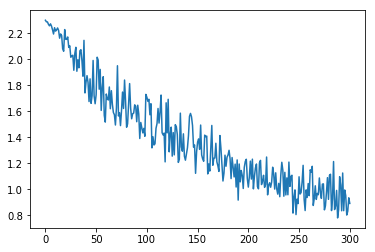

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))